In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn import metrics

import seaborn as sns
from scipy import stats

In [3]:
PATH = "data/santander/"

In [4]:
!ls {PATH}

sample_submission.csv test.csv              train.csv


In [6]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [7]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/santander')

In [5]:
df_raw = pd.read_feather('tmp/santander')

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Data Exploration

The data used in this notebook is from the Santander customer satisfaction competition on [kaggle](https://www.kaggle.com/c/santander-customer-satisfaction).  The aim of this competition is to predict the probability of the target variable, which is a proxy for customer satisfaction using the other variables provided about that customer.

We will begin by exploring the data a bit to see what we can learn.  We will then start building random forests.

In [7]:
df_raw.shape

(76020, 371)

We can see from the above that we have 371 different columns for each data point.  This means that it will be too time consuming to explore each column individually.  Instead, lets try to learn about the target column, find out the type of each column and explore the data types of the columns.

### Target variable

In [8]:
target = df_raw["TARGET"]

In [9]:
# see the unique values in the target variable
np.unique(target)

array([0, 1])

In [10]:
# see the proportion of entries which are a 1
np.mean(target)

0.0395685345961589

In [11]:
# count the number of non-zero entries
np.count_nonzero(target)

3008

From the above we can see that the target variable is binary (0 or 1) and approximately 4% of the training data provided is 1 (approx 3k out of 76k entries).

### Data Types of columns

A good starting point will be to check whether any of the columns are provided in a non-numerical data type.  While doing this we can also look at the names of the columns, their features (mean, quartiles, unique values etc.) and whether they include missing data.

In [12]:
df_raw_stats = df_raw.drop("ID", axis=1).describe().T # drop ID as we know that this is unique
df_raw_stats["unique"] = pd.Series([df_raw[col].unique().size for col in df_raw.columns], index=df_raw.columns)
df_raw_stats["dtype"] = df_raw.dtypes
df_raw_stats["mode"] = pd.Series([df_raw[col].value_counts().idxmax() for col in df_raw.columns], index=df_raw.columns)
df_raw_stats["mode_freq"] = pd.Series([df_raw[col].value_counts().max() for col in df_raw.columns], index=df_raw.columns)

In [13]:
display_all(df_raw_stats.sort_values(by="unique", axis=0, ascending=False))

,count,mean,std,min,25%,50%,75%,max,unique,dtype,mode,mode_freq
var38,76020.0,1.172358e+05,1.826646e+05,5163.75,67870.6125,106409.16,118756.2525,2.203474e+07,57736,float64,117310.979016,14868
saldo_medio_var5_ult3,76020.0,1.048856e+03,8.189949e+03,-476.07,0.0000,2.73,83.7900,5.443656e+05,17330,float64,0.000000,24664
saldo_var30,76020.0,1.367967e+04,6.301408e+04,-4942.26,0.0000,3.00,235.9950,3.458077e+06,16940,float64,0.000000,20310
saldo_var42,76020.0,7.191725e+03,4.914531e+04,-4942.26,0.0000,3.00,120.0000,3.008077e+06,15730,float64,0.000000,21786
saldo_medio_var5_ult1,76020.0,1.077257e+03,9.614907e+03,-922.38,0.0000,3.00,90.0000,6.014286e+05,14778,float64,0.000000,24664
saldo_medio_var5_hace2,76020.0,1.579135e+03,1.214845e+04,-128.37,0.0000,3.00,90.0000,8.121373e+05,14486,float64,0.000000,23241
saldo_var5,76020.0,1.028468e+03,9.852140e+03,-2895.72,0.0000,3.00,90.0000,6.193292e+05,11642,float64,0.000000,25561
imp_op_var39_comer_ult3,76020.0,1.195296e+02,5.462663e+02,0.00,0.0000,0.00,0.0000,2.102481e+04,9099,float64,0.000000,64330
imp_op_var41_comer_ult3,76020.0,1.130569e+02,5.121548e+02,0.00,0.0000,0.00,0.0000,1.656681e+04,8961,float64,0.000000,64480
imp_op_var39_ult1,76020.0,1.404035e+02,7.127672e+02,0.00,0.0000,0.00,0.0000,4.759809e+04,8149,float64,0.000000,64271


In [53]:
# Start a list of the variables to drop
# These are the variables with zero variance
to_drop = list(df_raw_stats[df_raw_stats["std"] == 0].index)
to_drop.extend(["ID", "TARGET"])
len(to_drop)

36

In [15]:
# See if any columns have a count that is smaller than 76020
len(list(df_raw_stats[df_raw_stats["count"] != 76020].index))

0

In [16]:
# look at the variables with unusual negative values
df_raw_stats[df_raw_stats["min"] < 0][["min", "25%", "50%", "75%", "max"]].sort_values(by="min")

,min,25%,50%,75%,max
var3,-999999.00,2.0,2.00,2.0000,2.380000e+02
saldo_var8,-4942.26,0.0,0.00,0.0000,2.400450e+05
saldo_var30,-4942.26,0.0,3.00,235.9950,3.458077e+06
saldo_var42,-4942.26,0.0,3.00,120.0000,3.008077e+06
saldo_medio_var8_ult1,-3401.34,0.0,0.00,0.0000,2.280318e+05
saldo_var5,-2895.72,0.0,3.00,90.0000,6.193292e+05
saldo_medio_var8_ult3,-1844.52,0.0,0.00,0.0000,1.775820e+05
saldo_medio_var5_ult1,-922.38,0.0,3.00,90.0000,6.014286e+05
saldo_medio_var5_ult3,-476.07,0.0,2.73,83.7900,5.443656e+05
saldo_medio_var8_hace2,-287.67,0.0,0.00,0.0000,2.313520e+05


/Users/danielmarcus/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


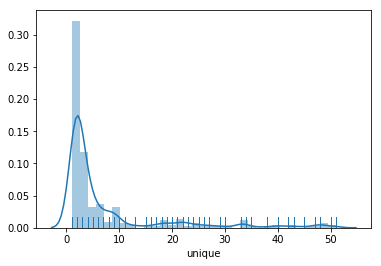

In [17]:
# Use seaborn to visualise the unique values
sns.distplot(df_raw_stats[df_raw_stats["unique"] < 60]["unique"], rug="true")

In [18]:
# look for potential anomolies using mode
display_all(df_raw_stats.sort_values(by="mode", axis=0, ascending=False).head(20))

,count,mean,std,min,25%,50%,75%,max,unique,dtype,mode,mode_freq
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76,57736,float64,117310.979016,14868
var36,76020.0,40.449079,47.362719,0.00,2.0000,3.00,99.0000,99.00,5,int64,99.000000,30064
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00,100,int64,23.000000,20170
num_var42,76020.0,2.217995,1.497703,0.00,0.0000,3.00,3.0000,18.00,7,int64,3.000000,52064
num_var42_0,76020.0,3.204144,0.944123,0.00,3.0000,3.00,3.0000,114.00,8,int64,3.000000,70242
num_var41_0,76020.0,2.699250,1.105297,0.00,3.0000,3.00,3.0000,33.00,9,int64,3.000000,65398
num_var39_0,76020.0,2.724941,1.139159,0.00,3.0000,3.00,3.0000,33.00,9,int64,3.000000,65013
num_var35,76020.0,3.299369,2.868217,0.00,0.0000,3.00,3.0000,36.00,13,int64,3.000000,37921
num_var30,76020.0,2.382873,1.642787,0.00,0.0000,3.00,3.0000,33.00,9,int64,3.000000,51452
num_var30_0,76020.0,3.371863,1.336654,0.00,3.0000,3.00,3.0000,114.00,11,int64,3.000000,68086


In [19]:
display_all(df_raw_stats.sort_values(by="mode", axis=0, ascending=False).tail(5))

,count,mean,std,min,25%,50%,75%,max,unique,dtype,mode,mode_freq
num_op_var41_hace3,76020.0,0.093923,1.215218,0.0,0.0,0.0,0.0,81.0,22,int64,0.0,75044
num_op_var41_hace2,76020.0,1.601144,7.322004,0.0,0.0,0.0,0.0,249.0,51,int64,0.0,67679
num_op_var40_ult3,76020.0,0.078295,2.558216,0.0,0.0,0.0,0.0,351.0,35,int64,0.0,75772
num_op_var40_ult1,76020.0,0.057024,1.827374,0.0,0.0,0.0,0.0,234.0,30,int64,0.0,75791
TARGET,76020.0,0.039569,0.194945,0.0,0.0,0.0,0.0,1.0,2,int64,0.0,73012


In [20]:
var3_counts = df_raw["var3"].value_counts().reset_index().sort_values(by="var3", ascending=False)
var3_counts.head()

,index,var3
0,2,74165
1,8,138
2,-999999,116
3,9,110
4,3,108


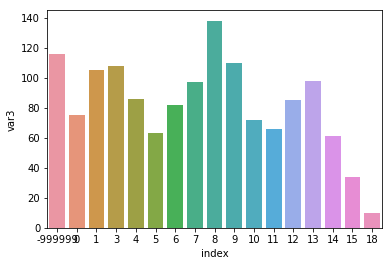

In [21]:
# plot var3_counts, filtering out the extremes
sns.barplot(x="index", y="var3", data=var3_counts[(var3_counts["var3"] >= 10) & (var3_counts["var3"] <= 1000)])

There are a few things we can note from this very quick analysis:
* There are 34 columns that we can drop straight away as they have zero variance in the training data.  We have added these to a python list called to_drop.  We will populate this list further as we do more analysis.
* All of the variables are numeric (either int64 or float64 in data type)
* None of the variables immediately appear by their column name or data structure to be dates
* There are quite a few clearly categorical variables (see seaborn plot above).  When we have fewer variables we could work at converting some of these into dummies to see if there is a particular value that causes an effect on the target.
* var3 is a semi-categorical variable that has a single extreme value deeply in the negative.  This suggests that the deeply negative value is an unknown value, we can choose to handle this appropriately later.
* var38 looks like it has had missing values replaced with the mean (there are approx 15k entries with a value very close to the mean, yet there are 58k unique entries in the training set of 76k entries)

## Train Validation Split

Use random train/valid split, but stratify to ensure that we split our target variables appropriately across the two data sets (since 4% is a low probability a truly random sample could get almost no relevant data).

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(df_raw.drop(to_drop, axis=1), df_raw["TARGET"], stratify=df_raw["TARGET"], test_size=0.20)

In [23]:
X_valid.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
51864,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51531.27
21959,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51721.80
34521,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163515.90
28536,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52534.53
37106,0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71151.24


## First random forest

In [38]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_features='sqrt', min_samples_leaf=5)

In [39]:
%time m.fit(X_train, y_train)

CPU times: user 47.1 s, sys: 543 ms, total: 47.7 s
Wall time: 14 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1])

0.9280762881929456

In [41]:
metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1])

0.8215811241440099

## Feature Importance

Since our starting model seems to be pretty good, let's see what the feature importance looks like when we use it.

In [42]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
1,var15,0.141838
334,var38,0.063610
164,saldo_var30,0.044868
171,saldo_var42,0.036547
295,saldo_medio_var5_hace2,0.034020
297,saldo_medio_var5_ult1,0.032602
298,saldo_medio_var5_ult3,0.030724
296,saldo_medio_var5_hace3,0.026742
148,saldo_var5,0.026440
294,num_var45_ult3,0.020964


In [43]:
fi[fi["imp"] == 0]

,cols,imp
331,saldo_medio_var44_hace3,0.0
315,saldo_medio_var13_medio_hace2,0.0
317,saldo_medio_var13_medio_ult3,0.0
330,saldo_medio_var44_hace2,0.0
316,saldo_medio_var13_medio_ult1,0.0
284,num_trasp_var17_in_ult1,0.0
24,ind_var6,0.0
318,saldo_medio_var17_hace2,0.0
286,num_trasp_var33_in_hace3,0.0
322,saldo_medio_var29_hace2,0.0


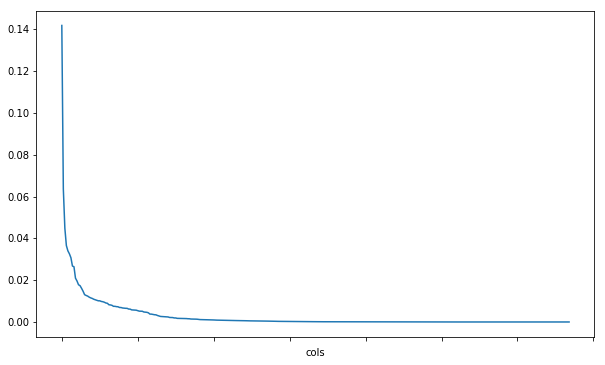

In [44]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [45]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

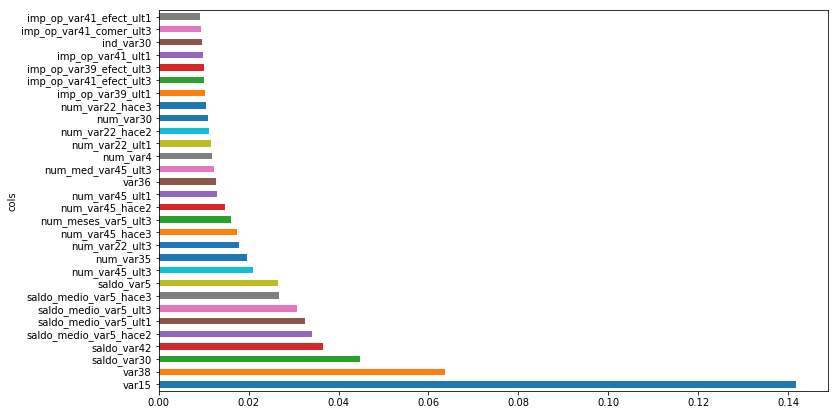

In [46]:
plot_fi(fi[:30]);

### Experiment 1: Drop all columns with 0 importance

The above analysis shows that there are 89 columns given zero importance in our model, even when we are using 200 decision trees in our random forest.  Lets try dropping these columns and seeing whether it affects our random forest efficacy.

In [47]:
zero_importance = list(fi[fi["imp"] == 0].cols)

In [54]:
to_drop.extend(zero_importance)

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(df_raw.drop(to_drop, axis=1), df_raw["TARGET"], stratify=df_raw["TARGET"], test_size=0.20)

In [57]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_features='sqrt', min_samples_leaf=5)

In [58]:
%time m.fit(X_train, y_train)

CPU times: user 44.2 s, sys: 522 ms, total: 44.7 s
Wall time: 14.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1])

0.9318380061374272

In [60]:
metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1])

0.828043853274548

In [62]:
X_train.shape

(60816, 246)

As expected, this experiment was a success.  The removal of the columns which had zero importance gave us a better performing model.  We have now reduced our columns to 246.

We can probably go a lot further than this.  We will try to do so in another experiment.

### Experiment 2: Improve missing value replacement in var38

We previously identified that var38 looks like it has had missing value replacement - a lot of the variables are set to a value that is equal to the mean of the other fields.  We are going to experiment to see if adding a field called var38_missing and using a random forest to predict these missing values.

In [68]:
df_raw["var38_missing"] = (df_raw["var38"] < 117311) & (df_raw["var38"] > 117300)

In [71]:
missing_var38_df = df_raw[df_raw["var38_missing"] == True].drop(["TARGET","var38"], axis=1)
missing_var38_df.head(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38_missing
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
16,36,2,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
22,51,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
24,56,2,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
34,83,2,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
37,88,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
70,146,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
76,154,2,72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
78,156,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
79,157,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [70]:
has_var38_df = df_raw[df_raw["var38_missing"] == False]

In [73]:
X_var38_train, X_var38_valid, y_var38_train, y_var38_valid = train_test_split(has_var38_df.drop(["TARGET", "var38"], axis=1), has_var38_df["var38"], test_size=0.20)

In [74]:
X_var38_train.shape

(48919, 370)

In [87]:
m_var38 = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_features='sqrt', min_samples_leaf=5)

In [88]:
%time m_var38.fit(X_var38_train, y_var38_train)

CPU times: user 42.9 s, sys: 509 ms, total: 43.4 s
Wall time: 14 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [89]:
m_var38.score(X_var38_train, y_var38_train)

0.1280694380338011

In [90]:
m_var38.score(X_var38_valid, y_var38_valid)

-0.0003751063230756913

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(df_raw.drop(to_drop, axis=1), df_raw["TARGET"], stratify=df_raw["TARGET"], test_size=0.20)

In [92]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_features='sqrt', min_samples_leaf=5)

In [93]:
%time m.fit(X_train, y_train)

CPU times: user 45.8 s, sys: 559 ms, total: 46.3 s
Wall time: 14.6 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1])

0.9334300391519632

In [95]:
metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1])

0.8270907116441975

In [96]:
fi = rf_feat_importance(m, X_train)

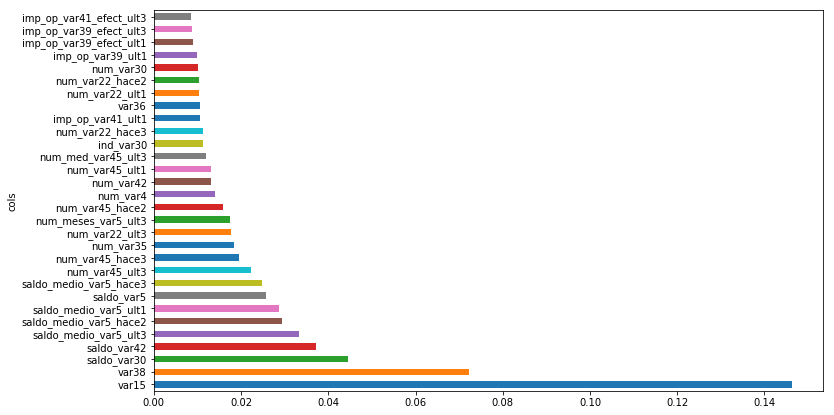

In [97]:
plot_fi(fi[:30]);

In [101]:
fi[fi["cols"] == "var38_missing"]

,cols,imp
246,var38_missing,0.004238


The conclusion of experiment 2 is that it isn't worth playing with var38 for the purposes of making the model more accurate.  It is not sufficiently correlated with the other variables to be predictable by those variables and the information about whether or not it is missing is already contained in the raw data in a manner the random forest can use, without any further extraction.